# Importar os dados


In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import davies_bouldin_score
from adjustText import adjust_text
import plotly.io as pio
import plotly.graph_objects as go

file_path = "./Missing_Migrants_Global_Figures_allData.xlsx"
df = pd.read_excel(file_path)
display(df.head())

,Main ID,Incident ID,Incident Type,Region of Incident,Incident Date,Incident Year,Month,Number of Dead,Minimum Estimated Number of Missing,Total Number of Dead and Missing,...,Region of Origin,Cause of Death,Country of Incident,Migration Route,Location of Incident,Coordinates,UNSD Geographical Grouping,Information Source,URL,Source Quality
0,2014.MMP00001,2014.MMP00001,Incident,North America,2014-01-06,2014.0,January,1.0,NaN,1,...,Central America,Mixed or unknown,United States of America,US-Mexico border crossing,Pima Country Office of the Medical Examiner ju...,"31.650259, -110.366453",Northern America,Pima County Office of the Medical Examiner (PC...,http://humaneborders.info/,5
1,2014.MMP00002,2014.MMP00002,Incident,North America,2014-01-12,2014.0,January,1.0,NaN,1,...,Latin America / Caribbean (P),Mixed or unknown,United States of America,US-Mexico border crossing,Pima Country Office of the Medical Examiner ju...,"31.59713, -111.73756",Northern America,Pima County Office of the Medical Examiner (PC...,NaN,5
2,2014.MMP00003,2014.MMP00003,Incident,North America,2014-01-14,2014.0,January,1.0,NaN,1,...,Latin America / Caribbean (P),Mixed or unknown,United States of America,US-Mexico border crossing,Pima Country Office of the Medical Examiner ju...,"31.94026, -113.01125",Northern America,Pima County Office of the Medical Examiner (PC...,NaN,5
3,2014.MMP00004,2014.MMP00004,Incident,North America,2014-01-16,2014.0,January,1.0,NaN,1,...,Central America,Violence,United States of America,US-Mexico border crossing,"near Douglas, Arizona, USA","31.506777, -109.315632",Northern America,"Ministry of Foreign Affairs Mexico, Pima Count...",http://bit.ly/1qfIw00,5
4,2014.MMP00005,2014.MMP00005,Incident,Europe,2014-01-16,2014.0,January,1.0,0.0,1,...,Northern Africa,Harsh environmental conditions / lack of adequ...,Russian Federation,NaN,Border between Russia and Estonia,"59.1551, 28",Northern Europe,EUBusiness (Agence France-Presse),http://bit.ly/1rTFTjR,1


# Análise Descritiva dos Dados

In [97]:
display(df.describe())

,Incident Year,Number of Dead,Minimum Estimated Number of Missing,Total Number of Dead and Missing,Number of Survivors,Number of Females,Number of Males,Number of Children
count,19242.000000,18499.000000,1657.000000,19255.000000,2901.000000,5698.000000,12936.000000,4254.000000
mean,2020.158559,2.377264,18.345806,3.862685,38.793175,1.155669,1.665198,0.953691
std,3.027439,8.861996,43.001607,17.542329,92.288494,3.683906,4.386550,4.299888
min,2014.000000,0.000000,-13.000000,1.000000,-1.000000,0.000000,0.000000,0.000000
25%,2018.000000,1.000000,2.000000,1.000000,4.000000,0.000000,1.000000,0.000000
50%,2021.000000,1.000000,6.000000,1.000000,13.000000,1.000000,1.000000,1.000000
75%,2023.000000,1.000000,18.000000,2.000000,38.000000,1.000000,1.000000,1.000000
max,2025.000000,750.000000,750.000000,1022.000000,1950.000000,168.000000,135.000000,250.000000


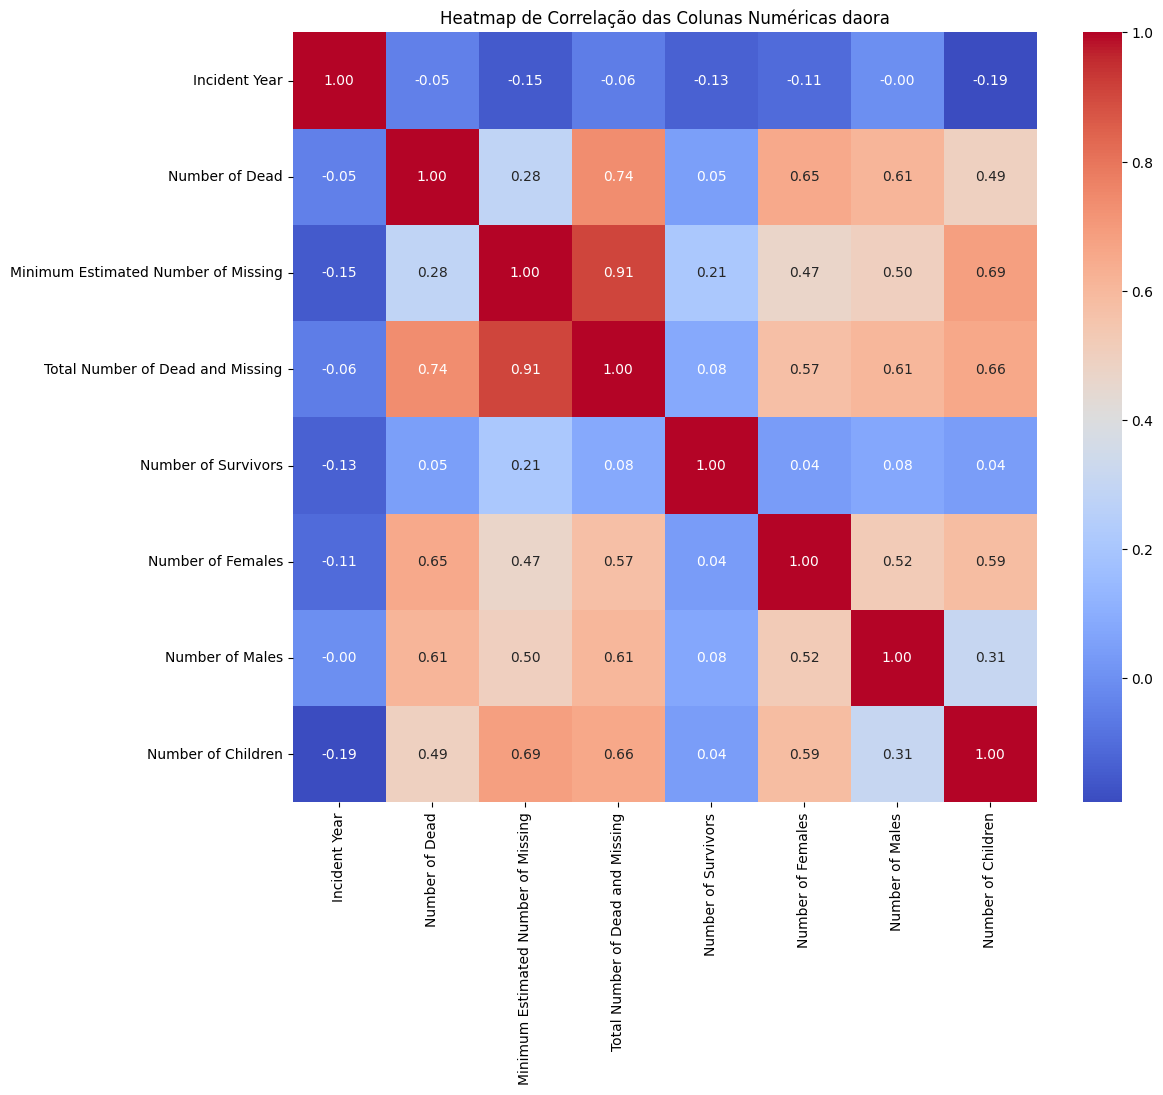

In [98]:
# Selecionar apenas colunas numéricas para análise de correlação
numerical_cols = df.select_dtypes(include=np.number).columns

# Calcular a matriz de correlação
correlation_matrix = df[numerical_cols].corr()

# Gerar o heatmap
import seaborn as sns
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap de Correlação das Colunas Numéricas daora')
plt.show()

In [99]:
cols_to_use = ['Migration Route', 'Total Number of Dead and Missing', 'Number of Survivors']
df_routes = df[cols_to_use].copy()


print("Rotas Nan: " + str(df_routes['Migration Route'].isnull().sum()))
print('% Rotas Nan: ' + str(df_routes['Migration Route'].isnull().sum() / len(df_routes) * 100))

print("\nNúmero de valores NaN na coluna 'Total Number of Dead and Missing':", end=' ')
print(str(df_routes['Total Number of Dead and Missing'].isnull().sum()))
print('% Rotas Nan: ' + str(df_routes['Total Number of Dead and Missing'].isnull().sum() / len(df_routes) * 100))

print("\nNúmero de valores NaN na coluna 'Number of Survivors':", end=' ')
print(str(df_routes['Number of Survivors'].isnull().sum()))
print('% Rotas Nan: ' + str(df_routes['Number of Survivors'].isnull().sum() / len(df_routes) * 100))

Rotas Nan: 2656
% Rotas Nan: 13.793819787068292

Número de valores NaN na coluna 'Total Number of Dead and Missing': 0
% Rotas Nan: 0.0

Número de valores NaN na coluna 'Number of Survivors': 16354
% Rotas Nan: 84.93378343287458


## Corrigindo valores

In [100]:
# Apagar linhas com a rota de migração igual a NaN
df_routes.dropna(subset=['Migration Route'], inplace=True)

In [101]:
# Converter colunas numéricas de "erro/NaN" com 0

df_routes['Number of Survivors'] = pd.to_numeric(df_routes['Number of Survivors'], errors='coerce').fillna(0)

In [102]:
# Filtrar rotas por ocorrência 

# Contar ocorrências de cada rota de migração
route_counts = df_routes['Migration Route'].value_counts()

# Obter rotas que aparecem pelo menos 10 vezes
routes_to_keep = route_counts[route_counts >= 10].index
routes_to_exclude = route_counts[route_counts < 10].index

# Filtrar o banco de dados
df_filtered = df_routes[df_routes['Migration Route'].isin(routes_to_keep)].copy()

# Mostrar rotas mantidas com número de ocorrências
print("Rotas mantidas (ocorreram pelo menos 10 vezes):")
display(route_counts[route_counts >= 10].to_frame(name='Ocorrências'))

# Mostrar rotas excluídas com número de ocorrências
print("\nRotas excluídas (ocorreram menos de 10 vezes):")
display(route_counts[route_counts < 10].to_frame(name='Ocorrências'))


Rotas mantidas (ocorreram pelo menos 10 vezes):


,Ocorrências
Migration Route,
US-Mexico border crossing,5410
Afghanistan to Iran,3835
Sahara Desert crossing,2212
Central Mediterranean,1432
Western Mediterranean,764
Eastern Route to/from EHOA,566
Eastern Mediterranean,400
Western Africa / Atlantic route to the Canary Islands,332
Darien,246



Rotas excluídas (ocorreram menos de 10 vezes):


,Ocorrências
Migration Route,
DRC to Uganda,2
Caribbean to Central America,2
Horn of Africa to Yemen crossing,2
"Central Mediterranean,Sahara Desert crossing",1
"Central Mediterranean,US-Mexico border crossing",1


,Total Number of Dead and Missing,Number of Survivors
count,16591.000000,16591.000000
mean,3.804111,6.022904
std,17.068485,39.823876
min,1.000000,0.000000
25%,1.000000,0.000000
50%,1.000000,0.000000
75%,1.000000,0.000000
max,1022.000000,1950.000000


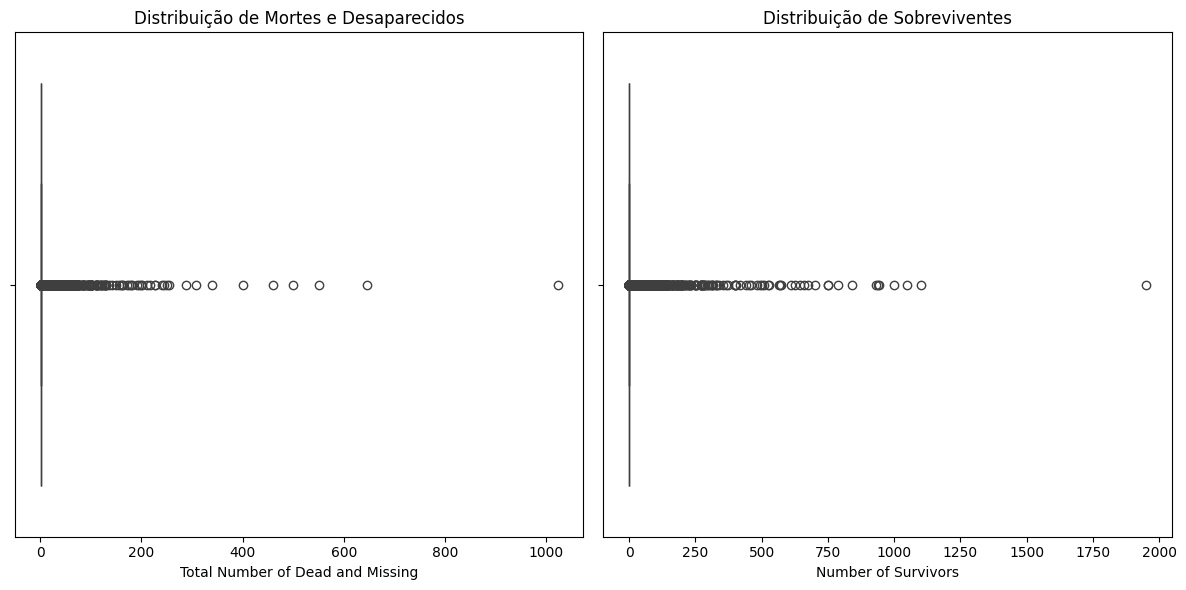

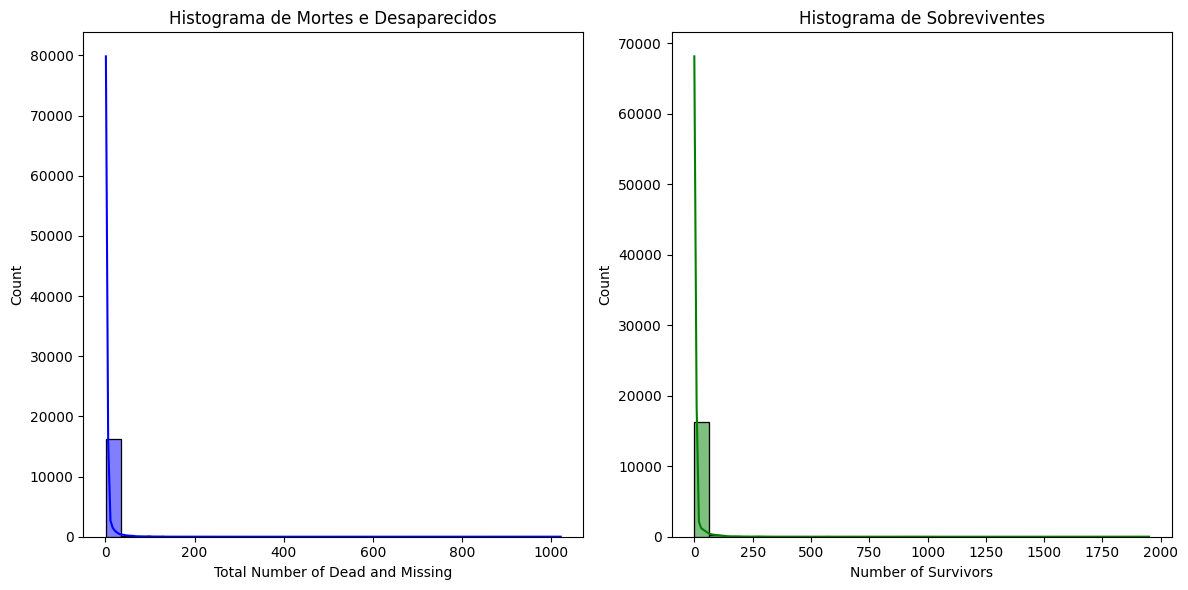

In [103]:
# Analisando dados melhorados
display(df_filtered.describe())
# Fazendo boxplot para visualizar a distribuição dos dados
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x='Total Number of Dead and Missing', data=df_filtered)
plt.title('Distribuição de Mortes e Desaparecidos')
plt.subplot(1, 2, 2)
sns.boxplot(x='Number of Survivors', data=df_filtered)
plt.title('Distribuição de Sobreviventes')
plt.tight_layout()
plt.show()

# Fazendo histogramas para visualizar a distribuição dos dados
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df_filtered['Total Number of Dead and Missing'], bins=30, kde=True
    , color='blue')
plt.title('Histograma de Mortes e Desaparecidos')
plt.subplot(1, 2, 2)
sns.histplot(df_filtered['Number of Survivors'], bins=30, kde=True, color='green')
plt.title('Histograma de Sobreviventes')
plt.tight_layout()
plt.show()


### Danger Ratio

In [104]:
# Calcular o dominador para as taxas de letalidade
denominator = df_filtered['Total Number of Dead and Missing'] + df_filtered['Number of Survivors']

# Calcular a taxa de perigo para cada incidente
df_filtered['Danger Ratio'] = np.divide(
    df_filtered['Total Number of Dead and Missing'],
    denominator,
    out=np.zeros_like(df_filtered['Total Number of Dead and Missing'], dtype=float),
    where=(denominator != 0)
)

# Calcula o número total de pessoas envolvidas em cada rota
df_filtered['Total People Involved'] = denominator


In [105]:
# Normalização dos dados

# Agrupamento dos dados
normalized_summary = df_filtered.groupby('Migration Route').agg(
    Mean_Danger_Ratio=('Danger Ratio', 'mean'),
    Mean_People_Involved=('Total People Involved', 'mean')
)
# Selecionando as características para escala
features_to_scale = normalized_summary[['Mean_Danger_Ratio', 'Mean_People_Involved']]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_to_scale)

# Modelos de IA

Foi escolhido dois modelos de agrupamento: K-means e Agrupamento Hierárquico

## Primeiro Modelo - K-means

In [113]:
# Número de clusters esclhidos: 3
k_optimal = 3
kmeans = KMeans(n_clusters=k_optimal, random_state=42, n_init=10)
normalized_summary['Cluster'] = kmeans.fit_predict(scaled_features)

# Análise de resultados
cluster_profiles = normalized_summary.groupby('Cluster')[['Mean_Danger_Ratio', 'Mean_People_Involved']].mean().sort_values('Mean_Danger_Ratio')
cluster_profiles['Quantidade'] = normalized_summary.groupby('Cluster').size()

print('--- Análise de Clusters com Dados Normalizados (k=3) ---')
print("\nPerfil Médio de Cada Cluster:")
print(cluster_profiles)

# Criar os clusters
profile_map = {
    cluster_profiles.index[0]: "Rotas com alta taxa de perigo e pucas pessoas envolvidas",
    cluster_profiles.index[1]: "Rotas com taxa de perigo média e número médio de pessoas envolvidas",
    cluster_profiles.index[2]: "Rotas com baixa taxa de perigo e muitas pessoas envolvidas",
}
normalized_summary['Cluster_Profile'] = normalized_summary['Cluster'].map(profile_map)

print("\n--- Detalhes dos Clusters (k=3) ---")
for cluster_label, profile_name in profile_map.items():
    print(f"\n--- Cluster: {profile_name} ---")
    cluster_data = normalized_summary[normalized_summary['Cluster'] == cluster_label]
    print(f"Número de Rotas: {len(cluster_data)}")
    print("Perfil Médio:")
    display(cluster_profiles.loc[cluster_label].round(2))
    print("\nRotas neste Cluster:")
    display(cluster_data.sort_values('Mean_People_Involved', ascending=False))


#Tabela com cada uma das rotas, seus valores e seu cluster
print("--- Tabela Final de Clusterização (K-Means, k=3) ---")
final_table_kmeans = normalized_summary[['Mean_Danger_Ratio', 'Mean_People_Involved', 'Cluster_Profile']].copy()
final_table_kmeans.sort_values(by=['Cluster_Profile', 'Mean_Danger_Ratio'], ascending=[True, False], inplace=True)
display(final_table_kmeans)

--- Análise de Clusters com Dados Normalizados (k=3) ---

Perfil Médio de Cada Cluster:
         Mean_Danger_Ratio  Mean_People_Involved  Quantidade
Cluster                                                     
2                 0.581712             57.120322           2
1                 0.703250             17.634271           8
0                 0.924519              3.625372          15

--- Detalhes dos Clusters (k=3) ---

--- Cluster: Rotas com alta taxa de perigo e pucas pessoas envolvidas ---
Número de Rotas: 2
Perfil Médio:


Mean_Danger_Ratio        0.58
Mean_People_Involved    57.12
Quantidade               2.00
Name: 2, dtype: float64


Rotas neste Cluster:


,Mean_Danger_Ratio,Mean_People_Involved,Cluster,Cluster_Profile
Migration Route,,,,
Western Africa / Atlantic route to the Canary Islands,0.471027,57.159639,2,Rotas com alta taxa de perigo e pucas pessoas ...
Central Mediterranean,0.692398,57.081006,2,Rotas com alta taxa de perigo e pucas pessoas ...



--- Cluster: Rotas com taxa de perigo média e número médio de pessoas envolvidas ---
Número de Rotas: 8
Perfil Médio:


Mean_Danger_Ratio        0.70
Mean_People_Involved    17.63
Quantidade               8.00
Name: 1, dtype: float64


Rotas neste Cluster:


,Mean_Danger_Ratio,Mean_People_Involved,Cluster,Cluster_Profile
Migration Route,,,,
Eastern Mediterranean,0.551102,25.617500,1,Rotas com taxa de perigo média e número médio ...
Venezuela to Caribbean,0.810088,20.416667,1,Rotas com taxa de perigo média e número médio ...
Dominican Republic to Puerto Rico,0.622821,19.137255,1,Rotas com taxa de perigo média e número médio ...
Sea crossings to Mayotte,0.722885,17.781250,1,Rotas com taxa de perigo média e número médio ...
Caribbean to US,0.645610,17.065789,1,Rotas com taxa de perigo média e número médio ...
Eastern Route to/from EHOA,0.760966,15.989399,1,Rotas com taxa de perigo média e número médio ...
Western Mediterranean,0.751539,14.420157,1,Rotas com taxa de perigo média e número médio ...
English Channel to the UK,0.760988,10.646154,1,Rotas com taxa de perigo média e número médio ...



--- Cluster: Rotas com baixa taxa de perigo e muitas pessoas envolvidas ---
Número de Rotas: 15
Perfil Médio:


Mean_Danger_Ratio        0.92
Mean_People_Involved     3.63
Quantidade              15.00
Name: 0, dtype: float64


Rotas neste Cluster:


,Mean_Danger_Ratio,Mean_People_Involved,Cluster,Cluster_Profile
Migration Route,,,,
Route to Southern Africa,0.866911,9.802083,0,Rotas com baixa taxa de perigo e muitas pessoa...
Iran to Türkiye,0.901589,6.235294,0,Rotas com baixa taxa de perigo e muitas pessoa...
Ukraine to Europe,0.855096,5.681818,0,Rotas com baixa taxa de perigo e muitas pessoa...
Haiti to Dominican Republic,0.882716,4.944444,0,Rotas com baixa taxa de perigo e muitas pessoa...
Türkiye-Europe land route,0.875481,4.564706,0,Rotas com baixa taxa de perigo e muitas pessoa...
Western Balkans,0.787995,4.348361,0,Rotas com baixa taxa de perigo e muitas pessoa...
Sahara Desert crossing,0.974355,4.151447,0,Rotas com baixa taxa de perigo e muitas pessoa...
Darien,0.957736,3.065041,0,Rotas com baixa taxa de perigo e muitas pessoa...
Syria to Türkiye,0.947367,3.038462,0,Rotas com baixa taxa de perigo e muitas pessoa...


--- Tabela Final de Clusterização (K-Means, k=3) ---


,Mean_Danger_Ratio,Mean_People_Involved,Cluster_Profile
Migration Route,,,
Central Mediterranean,0.692398,57.081006,Rotas com alta taxa de perigo e pucas pessoas ...
Western Africa / Atlantic route to the Canary Islands,0.471027,57.159639,Rotas com alta taxa de perigo e pucas pessoas ...
Northern Route from EHOA,1.000000,1.775510,Rotas com baixa taxa de perigo e muitas pessoa...
Afghanistan to Iran,0.994555,1.111343,Rotas com baixa taxa de perigo e muitas pessoa...
Horn of Africa Route,0.984375,1.535714,Rotas com baixa taxa de perigo e muitas pessoa...
Sahara Desert crossing,0.974355,4.151447,Rotas com baixa taxa de perigo e muitas pessoa...
US-Mexico border crossing,0.971993,1.511460,Rotas com baixa taxa de perigo e muitas pessoa...
Darien,0.957736,3.065041,Rotas com baixa taxa de perigo e muitas pessoa...
Italy to France,0.954630,1.194444,Rotas com baixa taxa de perigo e muitas pessoa...


Gráfico do Agrupamento não Hierárquico

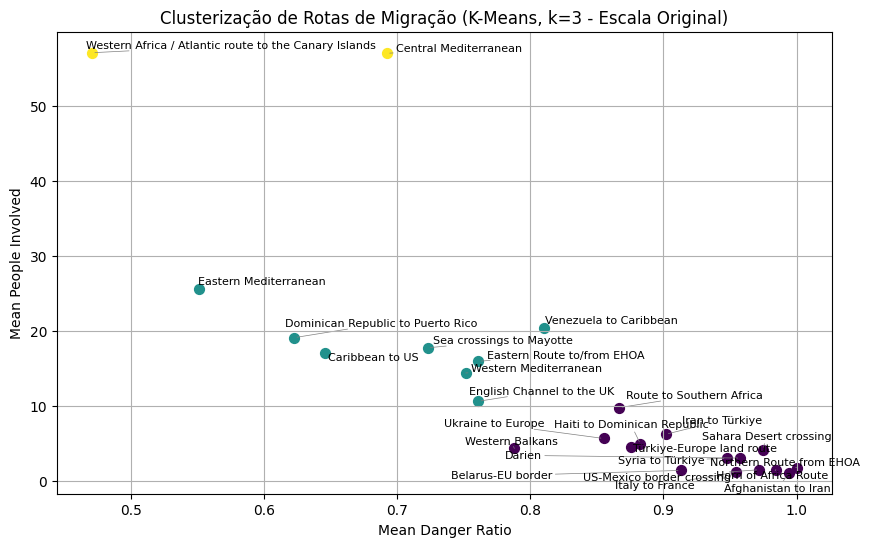

In [107]:

plt.figure(figsize=(10, 6))

# Obter os clusters únicos e criar um colormap manual
clusters = normalized_summary['Cluster'].unique()
colors = plt.cm.viridis(clusters / clusters.max())  # mapa de cores baseado nos clusters


# Plotar cada cluster separadamente para poder criar legenda
for cluster_id, color in zip(clusters, colors):
    cluster_data = normalized_summary[normalized_summary['Cluster'] == cluster_id]
    plt.scatter(
        cluster_data['Mean_Danger_Ratio'],
        cluster_data['Mean_People_Involved'],
        label=cluster_data['Cluster_Profile'].iloc[0],
        c=[color],
        s=50
    )


plt.xlabel('Mean Danger Ratio')
plt.ylabel('Mean People Involved')
plt.title('Clusterização de Rotas de Migração (K-Means, k=3 - Escala Original)')
plt.grid(True)


# Anotações com ajuste automático
texts = []
for i, route in enumerate(normalized_summary.index):
    x = normalized_summary['Mean_Danger_Ratio'].iloc[i]
    y = normalized_summary['Mean_People_Involved'].iloc[i]
    texts.append(plt.text(x, y, route, fontsize=8))

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

plt.show()


## Segundo Modelo - Hierárquico Bottom-Up (Aglomerativo)


--- Análise dos Clusters Hierárquicos (Letalidade vs. Escala) ---

Perfil Médio de Cada Cluster:
         Mean_Danger_Ratio  Mean_People_Involved
Cluster                                         
2                 0.581712             57.120322
0                 0.712666             16.158059
1                 0.934271              3.573730

--- Detalhes dos Clusters Hierárquicos ---

--- Cluster: Rotas com taxa de perigo média e número médio de pessoas envolvidas ---
Número de Rotas: 2
Perfil Médio:


Mean_Danger_Ratio        0.58
Mean_People_Involved    57.12
Name: 2, dtype: float64


Rotas neste Cluster:


,Mean_Danger_Ratio,Mean_People_Involved
Migration Route,,
Western Africa / Atlantic route to the Canary Islands,0.471027,57.159639
Central Mediterranean,0.692398,57.081006



--- Cluster: Rotas com alta taxa de perigo e pucas pessoas envolvidas ---
Número de Rotas: 9
Perfil Médio:


Mean_Danger_Ratio        0.71
Mean_People_Involved    16.16
Name: 0, dtype: float64


Rotas neste Cluster:


,Mean_Danger_Ratio,Mean_People_Involved
Migration Route,,
Eastern Mediterranean,0.551102,25.617500
Venezuela to Caribbean,0.810088,20.416667
Dominican Republic to Puerto Rico,0.622821,19.137255
Sea crossings to Mayotte,0.722885,17.781250
Caribbean to US,0.645610,17.065789
Eastern Route to/from EHOA,0.760966,15.989399
Western Mediterranean,0.751539,14.420157
English Channel to the UK,0.760988,10.646154
Western Balkans,0.787995,4.348361



--- Cluster: Rotas com baixa taxa de perigo e muitas pessoas envolvidas ---
Número de Rotas: 14
Perfil Médio:


Mean_Danger_Ratio       0.93
Mean_People_Involved    3.57
Name: 1, dtype: float64


Rotas neste Cluster:


,Mean_Danger_Ratio,Mean_People_Involved
Migration Route,,
Route to Southern Africa,0.866911,9.802083
Iran to Türkiye,0.901589,6.235294
Ukraine to Europe,0.855096,5.681818
Haiti to Dominican Republic,0.882716,4.944444
Türkiye-Europe land route,0.875481,4.564706
Sahara Desert crossing,0.974355,4.151447
Darien,0.957736,3.065041
Syria to Türkiye,0.947367,3.038462
Northern Route from EHOA,1.000000,1.775510


'--- Tabela Final de Clusterização (Hierárquico, n=3) ---'

,Mean_Danger_Ratio,Mean_People_Involved,Cluster_Profile
Migration Route,,,
Venezuela to Caribbean,0.810088,20.416667,Rotas com alta taxa de perigo e pucas pessoas ...
Western Balkans,0.787995,4.348361,Rotas com alta taxa de perigo e pucas pessoas ...
English Channel to the UK,0.760988,10.646154,Rotas com alta taxa de perigo e pucas pessoas ...
Eastern Route to/from EHOA,0.760966,15.989399,Rotas com alta taxa de perigo e pucas pessoas ...
Western Mediterranean,0.751539,14.420157,Rotas com alta taxa de perigo e pucas pessoas ...
Sea crossings to Mayotte,0.722885,17.781250,Rotas com alta taxa de perigo e pucas pessoas ...
Caribbean to US,0.645610,17.065789,Rotas com alta taxa de perigo e pucas pessoas ...
Dominican Republic to Puerto Rico,0.622821,19.137255,Rotas com alta taxa de perigo e pucas pessoas ...
Eastern Mediterranean,0.551102,25.617500,Rotas com alta taxa de perigo e pucas pessoas ...


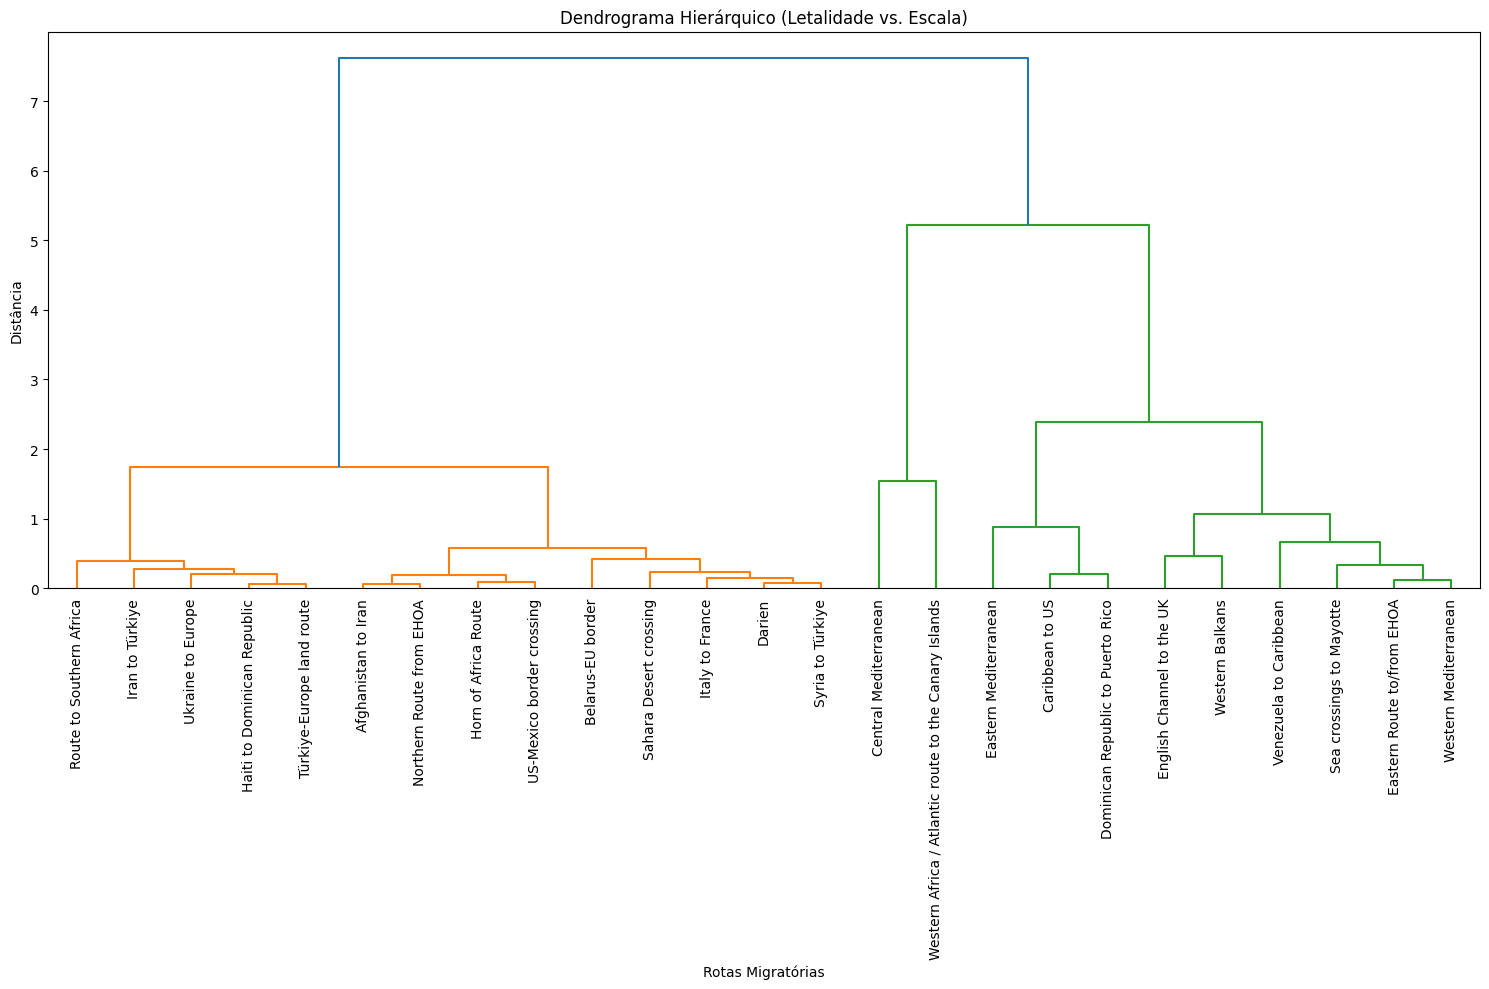

In [114]:
METHOD = 'ward'  # Método de ligação para o dendrograma
METRIC = 'euclidean'  # Métrica de distância para o dendrograma

# Gerar a matriz de ligação para o dendrograma
Z = linkage(scaled_features, method=METHOD, metric=METRIC)

# Definir summary_2d como uma cópia de normalized_summary
summary_2d = normalized_summary.copy()

# Criar e salvar o dendrograma
plt.figure(figsize=(15, 10))
plt.title('Dendrograma Hierárquico (Letalidade vs. Escala)')
plt.xlabel('Rotas Migratórias')
plt.ylabel('Distância')
dendrogram(
    Z,
    labels=summary_2d.index,
    leaf_rotation=90,
    leaf_font_size=10,
)
plt.tight_layout()


# Extrair 3 clusters para comparar com a análise de K-Means
n_clusters = 3
hc = AgglomerativeClustering(n_clusters=n_clusters, metric=METRIC, linkage=METHOD)
summary_2d['Cluster'] = hc.fit_predict(scaled_features)

# Análises de Clusters hierárquicos 
cluster_profiles = summary_2d.groupby('Cluster')[['Mean_Danger_Ratio', 'Mean_People_Involved']].mean().sort_values('Mean_Danger_Ratio')

print("\n--- Análise dos Clusters Hierárquicos (Letalidade vs. Escala) ---")
print("\nPerfil Médio de Cada Cluster:")
print(cluster_profiles)

# Criar nomes descritivos baseados nos perfis calculados
profile_map = {
    cluster_profiles.index[0]: "Rotas com taxa de perigo média e número médio de pessoas envolvidas",
    cluster_profiles.index[1]: "Rotas com alta taxa de perigo e pucas pessoas envolvidas",
    cluster_profiles.index[2]: "Rotas com baixa taxa de perigo e muitas pessoas envolvidas"
}
summary_2d['Cluster_Profile']= summary_2d['Cluster'].map(profile_map)


print("\n--- Detalhes dos Clusters Hierárquicos ---")
for cluster_label, profile_name in sorted(profile_map.items(), key=lambda item: cluster_profiles.loc[item[0]]['Mean_Danger_Ratio']):
    print(f"\n--- Cluster: {profile_name} ---")
    cluster_data = summary_2d[summary_2d['Cluster'] == cluster_label]
    print(f"Número de Rotas: {len(cluster_data)}")
    print("Perfil Médio:")
    display(cluster_profiles.loc[cluster_label].round(2))
    print("\nRotas neste Cluster:")
    display(cluster_data[['Mean_Danger_Ratio', 'Mean_People_Involved']].sort_values('Mean_People_Involved', ascending=False))


#Tabela com cada uma das rotas, seus valores e seu cluster
display("--- Tabela Final de Clusterização (Hierárquico, n=3) ---")
final_table_hc = summary_2d[['Mean_Danger_Ratio', 'Mean_People_Involved', 'Cluster_Profile']].copy()
final_table_hc.sort_values(by=['Cluster_Profile', 'Mean_Danger_Ratio'], ascending=[True, False], inplace=True)
display(final_table_hc)

# Resultados

In [109]:
# Scores para modelo k-means
kmeans_labels = kmeans.labels_
silhouette_kmeans = metrics.silhouette_score(scaled_features, kmeans_labels, metric='euclidean')
db_kmeans = davies_bouldin_score(scaled_features, kmeans_labels)
print("Silhouette Score (K-means):", silhouette_kmeans)
print("Davies Bouldin Score (K-Means):", db_kmeans, "\n")

# Scores para modelo hierárquico
hc_labels = hc.labels_
silhouette_hc = metrics.silhouette_score(scaled_features, hc_labels, metric='euclidean')
db_hc = davies_bouldin_score(scaled_features, hc_labels)
print("Silhouette Score (Hierárquico):", silhouette_hc)
print("Davies Bouldin Score (Hieráquico):", db_hc)



Silhouette Score (K-means): 0.6026273356901245
Davies Bouldin Score (K-Means): 0.5144832258840992 

Silhouette Score (Hierárquico): 0.5975642764531652
Davies Bouldin Score (Hieráquico): 0.5145514867248672


In [110]:
# Tabela cruzada entre os rótulos dos dois algoritmos
# Crie o DataFrame de comparação entre os clusters
comparison_df = pd.DataFrame({
    'KMeans_Cluster': normalized_summary['Cluster'],
    'Hierarchical_Cluster': summary_2d['Cluster']
}, index=normalized_summary.index)

confusion = pd.crosstab(comparison_df['KMeans_Cluster'], comparison_df['Hierarchical_Cluster'])

print("Matriz de comparação entre clusters KMeans e Hierárquico:")
display(confusion)

Matriz de comparação entre clusters KMeans e Hierárquico:


Hierarchical_Cluster,0,1,2
KMeans_Cluster,,,
0,1,14,0
1,8,0,0
2,0,0,2


In [111]:
grupo_diferente = (comparison_df['Hierarchical_Cluster'] == 0) & (comparison_df['KMeans_Cluster'] == 0)

print("Grupo diferente (KMeans 0, Hierárquico 0):")
display(comparison_df[grupo_diferente])

Grupo diferente (KMeans 0, Hierárquico 0):


,KMeans_Cluster,Hierarchical_Cluster
Migration Route,,
Western Balkans,0,0


In [ ]:
pio.renderers.default = "browser"

# Definir cores para cada cluster
cluster_colors = {
    0: 'blue',
    1: 'orange',
    2: 'green'
}

# Exemplo: dicionário com coordenadas de origem/destino para cada rota
coords_arrumadas = {
    'Afghanistan to Iran': {'origem_lat': 34.5, 'origem_lon': 69.1, 'destino_lat': 32.0, 'destino_lon': 54.0},
    'Belarus-EU border': {'origem_lat': 53.9, 'origem_lon': 27.5, 'destino_lat': 53.1, 'destino_lon': 23.1},
    'Caribbean to US': {'origem_lat': 18.0, 'origem_lon': -66.0, 'destino_lat': 25.7, 'destino_lon': -80.2},
    'Central Mediterranean': {'origem_lat': 33.8, 'origem_lon': 13.0, 'destino_lat': 37.6, 'destino_lon': 12.3},
    'Darien': {'origem_lat': 7.8, 'origem_lon': -77.5, 'destino_lat': 9.0, 'destino_lon': -79.5},
    'Dominican Republic to Puerto Rico': {'origem_lat': 18.5, 'origem_lon': -69.9, 'destino_lat': 18.5, 'destino_lon': -66.1},
    'Eastern Mediterranean': {'origem_lat': 36.2, 'origem_lon': 36.1, 'destino_lat': 38.0, 'destino_lon': 23.7},
    'Eastern Route to/from EHOA': {'origem_lat': 3.5, 'origem_lon': 42.0, 'destino_lat': 15.6, 'destino_lon': 45.2},
    'English Channel to the UK': {'origem_lat': 50.9, 'origem_lon': 1.8, 'destino_lat': 51.1, 'destino_lon': 1.3},
    'Haiti to Dominican Republic': {'origem_lat': 18.5, 'origem_lon': -72.3, 'destino_lat': 18.5, 'destino_lon': -69.9},
    'Horn of Africa Route': {'origem_lat': 12.0, 'origem_lon': 44.0, 'destino_lat': 15.6, 'destino_lon': 32.5},
    'Iran to Türkiye': {'origem_lat': 37.0, 'origem_lon': 45.0, 'destino_lat': 39.0, 'destino_lon': 43.0},
    'Italy to France': {'origem_lat': 43.7, 'origem_lon': 7.3, 'destino_lat': 43.8, 'destino_lon': 7.1},
    'Northern Route from EHOA': {'origem_lat': 9.0, 'origem_lon': 38.7, 'destino_lat': 15.0, 'destino_lon': 30.0},
    'Route to Southern Africa': {'origem_lat': 0.5, 'origem_lon': 32.5, 'destino_lat': -25.9, 'destino_lon': 28.2},
    'Sahara Desert crossing': {'origem_lat': 15.0, 'origem_lon': 1.0, 'destino_lat': 27.0, 'destino_lon': 13.0},
    'Sea crossings to Mayotte': {'origem_lat': -12.8, 'origem_lon': 45.2, 'destino_lat': -12.7, 'destino_lon': 45.1},
    'Syria to Türkiye': {'origem_lat': 36.2, 'origem_lon': 37.1, 'destino_lat': 37.1, 'destino_lon': 36.8},
    'Türkiye-Europe land route': {'origem_lat': 41.0, 'origem_lon': 28.9, 'destino_lat': 42.5, 'destino_lon': 22.5},
    'US-Mexico border crossing': {'origem_lat': 32.5, 'origem_lon': -117.0, 'destino_lat': 25.7, 'destino_lon': -100.3},
    'Ukraine to Europe': {'origem_lat': 50.4, 'origem_lon': 30.5, 'destino_lat': 52.5, 'destino_lon': 13.4},
    'Venezuela to Caribbean': {'origem_lat': 10.5, 'origem_lon': -66.9, 'destino_lat': 12.0, 'destino_lon': -61.8},
    'Western Africa / Atlantic route to the Canary Islands': {'origem_lat': 21.0, 'origem_lon': -17.0, 'destino_lat': 28.1, 'destino_lon': -15.4},
    'Western Balkans': {'origem_lat': 42.0, 'origem_lon': 21.0, 'destino_lat': 45.0, 'destino_lon': 15.0},
    'Western Mediterranean': {'origem_lat': 35.0, 'origem_lon': -2.9, 'destino_lat': 37.0, 'destino_lon': -1.8}
}


# Montar DataFrame para plotar
plot_df = []
for route, row in normalized_summary.iterrows():
    if route in coords_arrumadas:
        data = coords_arrumadas[route]
        plot_df.append({
            'origem_lat': data['origem_lat'],
            'origem_lon': data['origem_lon'],
            'destino_lat': data['destino_lat'],
            'destino_lon': data['destino_lon'],
            'cluster': row['Cluster'],
            'Migration Route': route
        })
plot_df = pd.DataFrame(plot_df)

# Plotar no mapa
fig = go.Figure()
for _, row in plot_df.iterrows():
    fig.add_trace(go.Scattergeo(
        lon = [row['origem_lon'], row['destino_lon']],
        lat = [row['origem_lat'], row['destino_lat']],
        mode = 'lines',
        line = dict(width = 2, color = cluster_colors[row['cluster']]),
        name = row['Migration Route']
    ))

fig.update_layout(
    title = 'Rotas de Migração por Cluster',
    showlegend = False,
    geo = dict(
        scope = 'world',
        projection_type = 'natural earth',
        showland = True,
        landcolor = 'rgb(243, 243, 243)',
        countrycolor = 'rgb(204, 204, 204)'
    )
)
fig.show()  
